In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.applications import ResNet152V2, Xception
import tensorflow_addons as tfa
import tensorflow as tf
from IPython.display import Image, display
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import tarfile
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import matplotlib.pyplot as plt

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"1Kt28zC5d3MRf8i9ZYLL1qaF_0PrpnIfX"})
downloaded.GetContentFile('img.tar.gz')
tarfile.open('img.tar.gz').extractall()
!rm -f img.tar.gz

downloaded = drive.CreateFile({'id':"1bUNyC5dlnVJXBd0LhXU08le9XYxiB4F_"})
downloaded.GetContentFile('train_data.csv')

downloaded = drive.CreateFile({'id':"1hqKXEI3n9_rjfJLLWFy_hwzWXw5Uyyu_"})
downloaded.GetContentFile('val_data.csv')

downloaded = drive.CreateFile({'id':"1rCEFjQ9v3Vwt1fTo5WNscU3wKz7kNeJR"})
downloaded.GetContentFile('test_data.csv')

In [0]:
train_data = pd.read_csv("train_data.csv")
train_data = train_data.sample(frac=1).reset_index(drop=True)

val_data = pd.read_csv("val_data.csv")
val_data = val_data.sample(frac=1).reset_index(drop=True)

test_data = pd.read_csv("test_data.csv")
test_data = test_data.sample(frac=1).reset_index(drop=True)

In [0]:
def fix_labels(num):
    num = int(num)
    if num > 45:
        num -= 1
    if num > 38:
        num -= 1
    if num > 31:
        num -= 1
    num -= 1
    return str(num)

train_data["category_label"] = train_data["category_label"].apply(lambda x:fix_labels(x))
val_data["category_label"] = val_data["category_label"].apply(lambda x:fix_labels(x))
test_data["category_label"] = test_data["category_label"].apply(lambda x:fix_labels(x))

In [0]:
num_classes = 45
model_resnet = ResNet152V2(weights="imagenet")

x = Dropout(0.50)(model_resnet.layers[-2].output)
x = Dense(500, activation="elu", kernel_regularizer=l2(l=0.001))(x)
x = Dropout(0.3)(x)
out_layer = Dense(num_classes, activation='softmax', kernel_regularizer=l2(l=0.01))(x)
model = Model(model_resnet.input, out_layer)

for layer in model.layers[:-29]:
    layer.trainable = False

lr_schedule = ExponentialDecay(0.0003, 1000, 0.9, staircase=True)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss="categorical_crossentropy",
              metrics=["accuracy", TopKCategoricalAccuracy(k=3)])

model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
num_classes = 45
model_xception = Xception(weights='imagenet')
x = Dropout(0.50)(model_xception.layers[-2].output)
x = Dense(500, activation="elu", kernel_regularizer=l2(l=0.001))(x)
x = Dropout(0.3)(x)
out_layer = Dense(num_classes, activation='softmax', kernel_regularizer=l2(l=0.01))(x)
model = Model(model_xception.input, out_layer)
for layer in model.layers[:-11]:
    layer.trainable = False

lr_schedule = ExponentialDecay(0.0001, 1000, 0.9, staircase=True)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss="categorical_crossentropy",
              metrics=["accuracy", TopKCategoricalAccuracy(k=3)])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

all_train_labels = tf.one_hot(train_data["category_label"].values.astype(np.int32), num_classes)
all_train_paths = train_data["image_name"].values
train_filepath_dataset = tf.data.Dataset.from_tensor_slices((all_train_paths, all_train_labels))

all_val_labels = tf.one_hot(val_data["category_label"].values.astype(np.int32), num_classes)
all_val_paths = val_data["image_name"].values
val_filepath_dataset = tf.data.Dataset.from_tensor_slices((all_val_paths, all_val_labels))

all_test_labels = tf.one_hot(test_data["category_label"].values.astype(np.int32), num_classes)
all_test_paths = test_data["image_name"].values
test_filepath_dataset = tf.data.Dataset.from_tensor_slices((all_test_paths, all_test_labels))

In [0]:
im_size = [224,224]
def get_image_and_label(filename, label):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, im_size)
    return (image, label)

def get_image_and_label_augment(filename, label):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, im_size)

    image = tfa.image.rotate(image, 30)
    image = tf.image.central_crop(image, .80)
    image = tf.image.resize(image, im_size)
    image = tfa.image.translate(image, translations=[20, 20])
    image = tf.image.random_flip_left_right(image)
    return (image, label)

def prepare_for_training(ds, batch_size=None, shuffle_buffer_size=1000, repeat=True):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    if repeat:
        ds = ds.repeat()
    if batch_size != None:
        ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [0]:
train_dataset = train_filepath_dataset.map(get_image_and_label, num_parallel_calls=AUTOTUNE)
train_dataset = prepare_for_training(train_dataset, batch_size=32)

val_dataset = val_filepath_dataset.map(get_image_and_label, num_parallel_calls=AUTOTUNE)
val_dataset = prepare_for_training(val_dataset, batch_size=32)

test_dataset = test_filepath_dataset.map(get_image_and_label, num_parallel_calls=AUTOTUNE)
test_dataset = prepare_for_training(test_dataset, batch_size=32)

In [0]:
class_weights = [99.94215784693341, 97.41718055356375, 91.50007170514843, 
                 99.89435441464697, 99.88096945360677, 95.44289880013385, 
                 99.89100817438693, 99.99426358812563, 99.74759787752761, 
                 98.60796405181893, 96.42143505903724, 99.74090539700751, 
                 99.77006549070224, 99.97036187198240, 99.72369616138438, 
                 95.47683923705722, 94.64936182417898, 87.26181939863282, 
                 96.52182226683875, 99.95315263635929, 99.97466418088818, 
                 99.81786892298867, 99.83173191835174, 99.43161719011425, 
                 99.98422486734547, 97.58305846359768, 99.78966489793967, 
                 99.98422486734547, 98.49753812323725, 98.26138916774224, 
                 93.15693866819637, 94.86495530379081, 98.94019790620966, 
                 99.61470433577131, 99.86137004636933, 99.98087862708543, 
                 99.26334910846599, 99.99521965677135, 75.00788756632727, 
                 97.84932358143314, 99.95602084229648, 99.19403413165065, 
                 99.97562024953392, 99.94932836177638, 97.42626320569816]

In [0]:
model.fit(train_dataset,
          validation_data=val_dataset,
          steps_per_epoch=2000,
          validation_steps=100,
          epochs=10,
          class_weight=class_weights)

Train for 2000 steps, validate for 100 steps
Epoch 1/10
2000/2000 [==============================] - 337s 168ms/step - loss: 2.3846 - accuracy: 0.5298 - top_k_categorical_accuracy: 0.7516 - val_loss: 1.8467 - val_accuracy: 0.5644 - val_top_k_categorical_accuracy: 0.7987
Epoch 2/10
2000/2000 [==============================] - 328s 164ms/step - loss: 1.6551 - accuracy: 0.5966 - top_k_categorical_accuracy: 0.8091 - val_loss: 1.5937 - val_accuracy: 0.5756 - val_top_k_categorical_accuracy: 0.8084
Epoch 3/10
2000/2000 [==============================] - 328s 164ms/step - loss: 1.4784 - accuracy: 0.6133 - top_k_categorical_accuracy: 0.8230 - val_loss: 1.4881 - val_accuracy: 0.5947 - val_top_k_categorical_accuracy: 0.8159
Epoch 4/10
2000/2000 [==============================] - 328s 164ms/step - loss: 1.3641 - accuracy: 0.6383 - top_k_categorical_accuracy: 0.8380 - val_loss: 1.4496 - val_accuracy: 0.6019 - val_top_k_categorical_accuracy: 0.8166
Epoch 5/10
2000/2000 [=============================

In [0]:
save_model(model, "resnet_opt.h5", include_optimizer=True, save_format=".h5")
save_model(model, "resnet.h5", include_optimizer=False, save_format=".h5")

In [0]:
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss="categorical_crossentropy",
              metrics=["accuracy", TopKCategoricalAccuracy(k=5)])
scores = model.evaluate(test_dataset, steps=1000)
print(scores)

In [0]:
im_number = 90
display(Image(test_data["image_name"][im_number]))

im = cv2.imread(test_data["image_name"][im_number])
im = cv2.resize(im, (299, 299))
im = np.expand_dims(im, axis=0)

print("expected label:", test_data["category_label"][im_number])
print("top 3 predicted labels: ")
print(np.argsort(model.predict(im)[0])[-3:])

In [0]:
n = 10000
label_names = pd.read_csv("label_names.csv")
label_names = label_names["category_name"].values
testing_data = test_data.sample(frac=1).reset_index(drop=True).iloc[:n]

all_testing_labels = tf.one_hot(testing_data["category_label"].values.astype(np.int32), num_classes)
all_testing_paths = testing_data["image_name"].values
testing_filepath_dataset = tf.data.Dataset.from_tensor_slices((all_testing_paths, all_testing_labels))

testing_dataset = testing_filepath_dataset.map(get_image_and_label, num_parallel_calls=AUTOTUNE)
testing_dataset = prepare_for_training(testing_dataset, batch_size=100, repeat=False)

actual_labels = testing_data["category_label"].values
predicted_labels = np.argmax(model.predict(testing_dataset), axis=1)

actual_labels = testing_data["category_label"].values
actual_labels = list(map(int, actual_labels))
predicted_labels = list(map(int, predicted_labels))

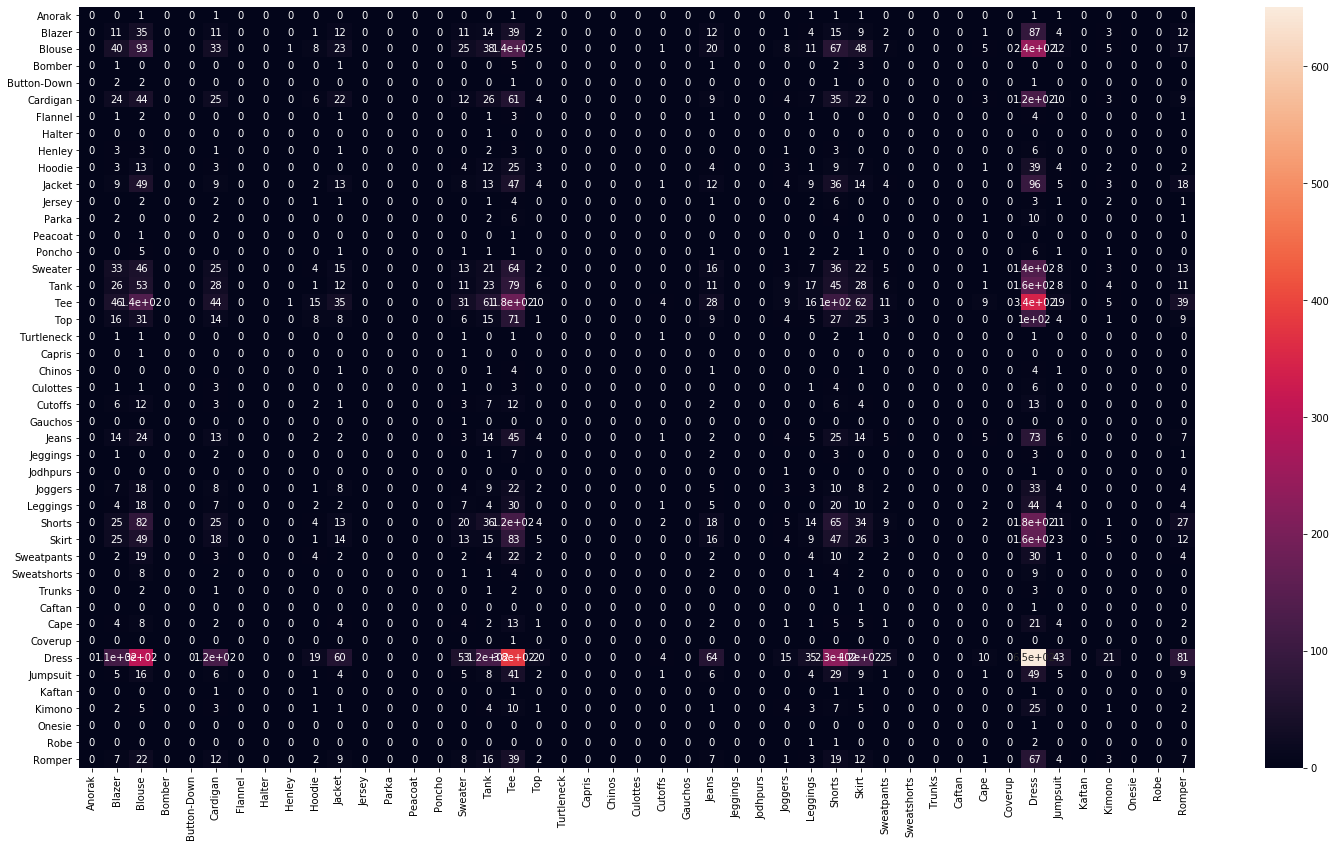

In [0]:
confusion_matrix = tf.math.confusion_matrix(actual_labels, predicted_labels, num_classes=num_classes)
confusion_matrix = np.array(confusion_matrix)
confusion_df = pd.DataFrame(confusion_matrix, index=label_names, columns=label_names)

plt.figure(figsize = (25, 14))
sns.heatmap(confusion_df, annot=True)
plt.show()